# Nashville weather forecast analysis

Ongoing analysis of weather forecast and observed weather data from the National Weather Service for Nashville, Tennessee. I am interested in visualizing the accuracy and precision of weather forecasts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
%matplotlib inline

In [2]:
# Retrieve data
forecast = pd.read_csv('forecastNash.csv', parse_dates=['endTime', 'startTime', 'retrievalDate'])
hourly_forecast = pd.read_csv('hourlyForecastNash.csv', parse_dates=['endTime', 'startTime', 'retrievalDate'])
observations = pd.read_csv('observedWeatherNash.csv', parse_dates=['retrievalDate', 'dateTime'])

### Working with the forecast data

In [3]:
# labeling the day number as the forecast day
number2day = {1:'day1', 2:'night1', 3:'day2', 4:'night2', 5:'day3', 6:'night3', 7:'day4', 8:'night4', 
              9:'day5', 10:'night5', 11:'day6', 12:'night6', 13:'day7', 14:'night7'}

forecast['forecastDay'] = forecast['number'].map(number2day)

The forecast rainfall amount is written out as text in the detailedForecast column. I need to extract it from each forecast where it is listed. When a range is given, I put the low and high estimates in their own columns. When no range is given, the amount listed is put in the high column, and zero in the low column.

In [4]:
# extract numerical rainfall amount forecast and assign them to low and high

rainList = ['tenth', 'quarter ', 'half', 'three', 'one', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
rainValue = [0.1, 0.25, 0.5, 0.75, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

low = []
high = []

for text in forecast['detailedForecast']:
    if 'New rainfall amounts' in text:
        out = text.split('.')
        if 'less than' in text:
            low.append(0.0)
            for i in range(len(rainList)):
                if rainList[i] in out[-2]:
                    high.append(rainValue[i])
        elif 'between' in text:
            textSplit = out[-2].split('and')
            for i in range(len(rainList)):
                if rainList[i] in textSplit[0]:
                    low.append(rainValue[i])
                if rainList[i] in textSplit[1]:
                    high.append(rainValue[i])
    else:
        high.append(0.0)
        low.append(0.0)

# Add rainfall amount forecasts to columns in the forecast DataFrame

forecast['rain low'] = low
forecast['rain high'] = high

Some of the dates in the forecast data are incorrect. I can fix them because I know what date I retrieved the data, so I can use the relative date they are at and the forecast number. The startTime can then be fixed by subtracting 12 hours from the endTime.

In [5]:
# Dictionary to encode the forecast number to the number of days after the forecast is retrieved
dateOffsetDict = {1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7}

forecast['value'] = forecast['number'].map(dateOffsetDict)

newTime = []
for index, row in forecast.iterrows():
    # Difference between  endDate and retrievalDate
    t = row['endTime'].date() - row['retrievalDate'].date()
    # Offset from endTime
    offset = (row['value'] - t.days)
    newTime.append(row['endTime'] + timedelta(days=offset))
    
forecast['endTime'] = newTime

# Calculate corrected startTime
forecast['startTime'] = forecast['endTime'] - timedelta(hours=12)

In [6]:
# split forecasts into daytime and nighttime only
dayForecast = forecast[forecast['isDaytime']]
nightForecast = forecast[~forecast['isDaytime']]

### working with the observed data

In [7]:
# Extract the wind speed and direction from text
observations[['windDir', 'windSpeed']] = observations['Wind(mph)'].str.split(n=1, expand=True)
observations['windSpeed'] = observations['windSpeed'].str.split(n=1).str[0]
observations['windSpeed'] = pd.to_numeric(observations['windSpeed'])

# Sort the observations in ascending order
observations.sort_values('dateTime', inplace=True)

In [8]:
shortObs = observations[['dateTime', 'retrievalDate', 'AirTemp', 'Dwpt', 'WindChill(°F)', 'HeatIndex(°F)', 
                         '1hrPrecip', 'windDir', 'windSpeed']]

Get the observations over the same time range as the daytime and nighttime forecasts. Need the maximum and minimum values of temperature, dewpoint, heat index, and windspeed for the daytime and nighttime observations, respectively. Need the sum of the observed precipitation and the most common wind direction for both the daytime and nighttime observations.

In [9]:
dayObs = []
nightObs = []

for i in range(len(dayForecast['startTime'].unique()[:-7])):
    # get observations for the same datetime range as the daytime forecasts
    temp = (shortObs[(shortObs['dateTime'] > dayForecast['startTime'].unique()[i]) & 
                     (shortObs['dateTime'] < dayForecast['endTime'].unique()[i])])
    dayObs.append({
        'startTime': dayForecast['startTime'].unique()[i],
        'endTime': dayForecast['endTime'].unique()[i],
        'AirTemp_obs': temp['AirTemp'].max(),
        'Dwpt_obs': temp['Dwpt'].max(),
        'HeatIndex_obs': temp['HeatIndex(°F)'].max(),
        'Precip_obs': temp['1hrPrecip'].sum(),
        'windDir_obs': temp['windDir'].value_counts().idxmax(),
        'windSpeed_obs': temp['windSpeed'].max()
    }
    )
    
    # get observations for the same datetime range as the nighttime forecasts
    temp1 = (shortObs[(shortObs['dateTime'] > nightForecast['startTime'].unique()[i]) & 
                     (shortObs['dateTime'] < nightForecast['endTime'].unique()[i])])
    nightObs.append({
        'startTime': nightForecast['startTime'].unique()[i],
        'endTime': nightForecast['endTime'].unique()[i],
        'AirTemp_obs': temp1['AirTemp'].min(),
        'Dwpt_obs': temp1['Dwpt'].min(),
        'HeatIndex_obs': temp1['HeatIndex(°F)'].min(),
        'Precip_obs': temp1['1hrPrecip'].sum(),
        'windDir_obs': temp1['windDir'].value_counts().idxmax(),
        'windSpeed_obs': temp1['windSpeed'].max()
    }
    )
    
dayObs = pd.DataFrame(dayObs)
nightObs = pd.DataFrame(nightObs)

allObs = pd.concat([dayObs, nightObs], ignore_index=True)
forecast_obs = pd.merge(left=forecast, right=allObs, on=['startTime', 'endTime'], how='right')

### Analysis

In [10]:
# Difference between the forecast and observations:
forecast_obs['tempDiff'] = forecast_obs['temperature'] - forecast_obs['AirTemp_obs']
forecast_obs['rainLowDiff'] = forecast_obs['rain low'] - forecast_obs['Precip_obs']
forecast_obs['rainHighDiff'] = forecast_obs['rain high'] - forecast_obs['Precip_obs']
forecast_obs['windLowDiff'] = forecast_obs['windSpeedMin'] - forecast_obs['windSpeed_obs']
forecast_obs['windHighDiff'] = forecast_obs['windSpeedMax'] - forecast_obs['windSpeed_obs']
# boolean column to mark whether it rained or not
forecast_obs['rain?'] = (forecast_obs['Precip_obs'] > 0)

In [11]:
# Get DataFrames for each forecast day/night

day1 = forecast_obs[forecast_obs['number'] == 1]
night1 = forecast_obs[forecast_obs['number'] == 2]
day2 = forecast_obs[forecast_obs['number'] == 3]
night2 = forecast_obs[forecast_obs['number'] == 4]
day3 = forecast_obs[forecast_obs['number'] == 5]
night3 = forecast_obs[forecast_obs['number'] == 6]
day4 = forecast_obs[forecast_obs['number'] == 7]
night4 = forecast_obs[forecast_obs['number'] == 8]
day5 = forecast_obs[forecast_obs['number'] == 9]
night5 = forecast_obs[forecast_obs['number'] == 10]
day6 = forecast_obs[forecast_obs['number'] == 11]
night6 = forecast_obs[forecast_obs['number'] == 12]
day7 = forecast_obs[forecast_obs['number'] == 13]
night7 = forecast_obs[forecast_obs['number'] == 14]

Plotting function to compare the forecast to the observations.

In [12]:
def plotForecast(df, variable='temperature'):
    """Plots temperature observations and forecasts bot in absolute measurements and relative to the 
    observations to show the differences.
    
    Args:
        df: DataFrame that contains data to plot from
        variable(str, optional): weather parameter to plot. Available options: 'temperature' (default), 
            'rainHigh', 'rainLow', 'windLow', and 'windHigh'.
    """
    # dictionary with list of column names needed to plot each type of weather data
    var = {'temperature': ['temperature', 'AirTemp_obs', 'tempDiff', 'Temperature (Farenheit)'], 
           'rainHigh': ['rain high', 'Precip_obs', 'rainHighDiff', 'Precipitation (inches)'], 
          'rainLow': ['rain low', 'Precip_obs', 'rainLowDiff', 'Precipitation (inches)'], 
          'windLow': ['windSpeedMin', 'windSpeed_obs', 'windLowDiff', 'Wind Speed (mph)'], 
          'windHigh': ['windSpeedMax', 'windSpeed_obs', 'windHighDiff', 'Wind Speed (mph)']}
    
    plt.subplots(figsize=(16,6))
    # forecast plot
    plt.subplot(1,2,1)
    plt.plot(df['endTime'], df[var[variable][1]], label='observed')
    plt.plot(df['endTime'], df[var[variable][0]], marker='o', linestyle='None', label='forecast')
    plt.xlabel('date')
    plt.ylabel(var[variable][3])
    plt.xticks(rotation=90)
    plt.title(df['forecastDay'].iloc[0] + ' forecast')
    plt.legend()
    
    # forecast difference plot
    plt.subplot(1,2,2)
    plt.plot(df['endTime'], (df[var[variable][1]] - df[var[variable][1]]), label='observed')
    plt.plot(df['endTime'], (df[var[variable][2]]), marker='o', linestyle='None', label='forecast')
    plt.xlabel('date')
    plt.ylabel(variable + ' difference\n (forecast - observed)')
    plt.xticks(rotation=90)
    plt.title(df['forecastDay'].iloc[0] + ' forecast difference')
    plt.legend();
    plt.show()

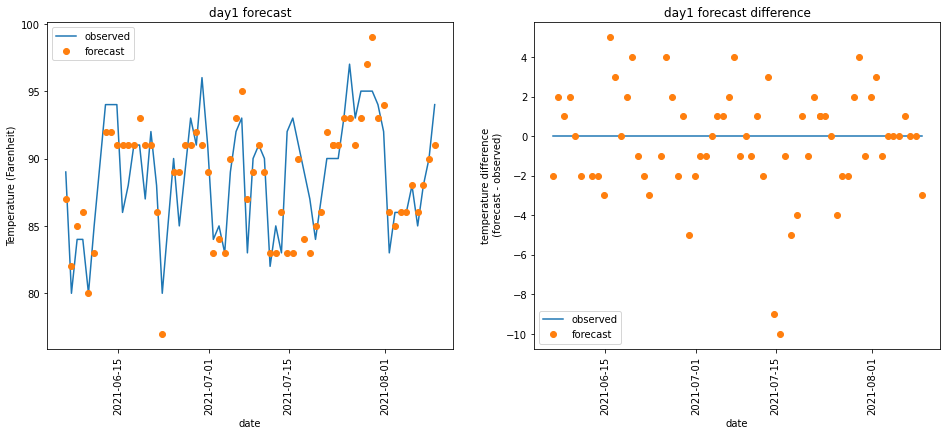

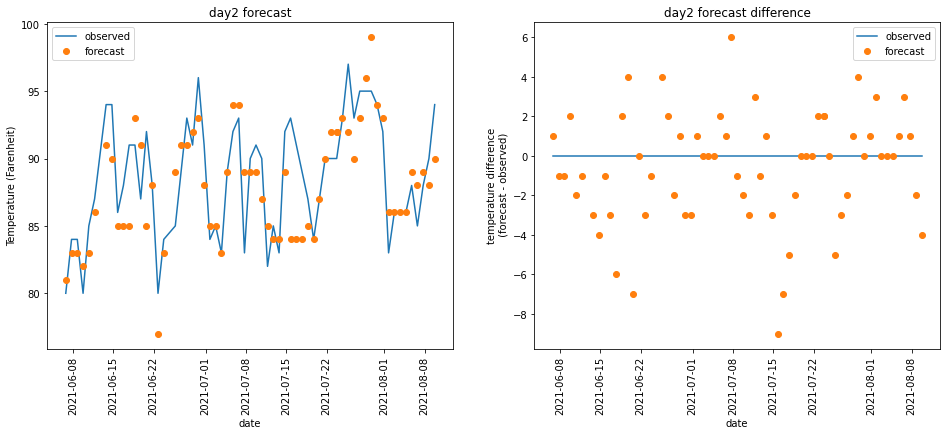

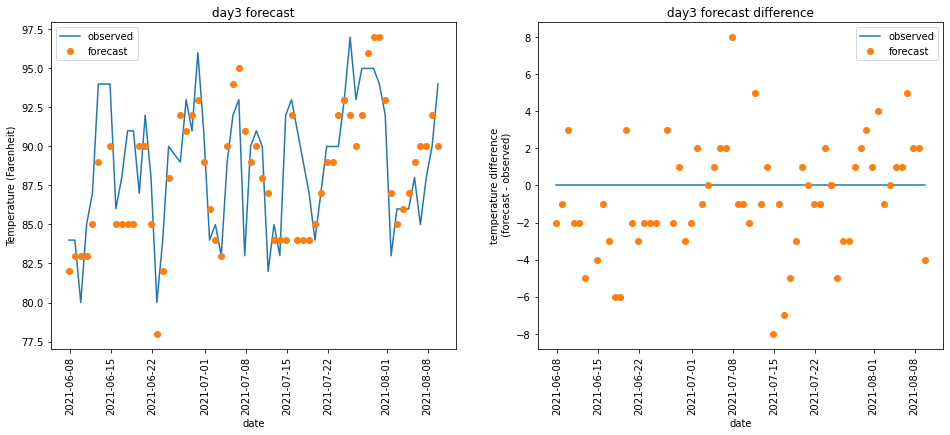

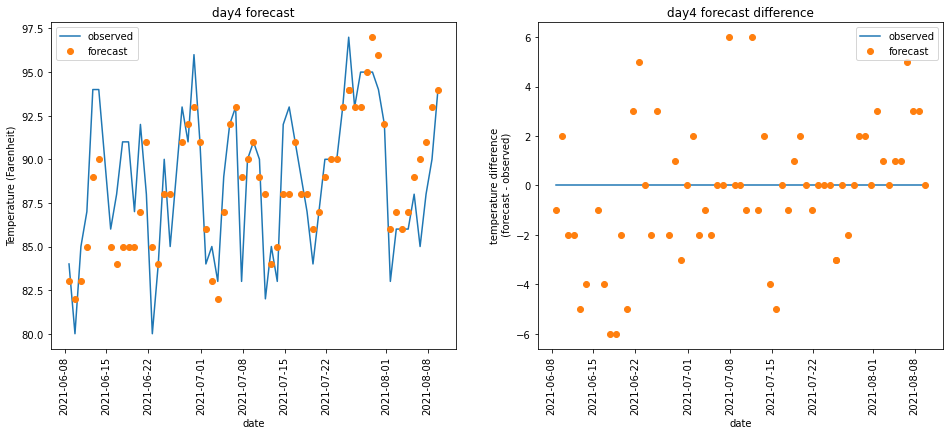

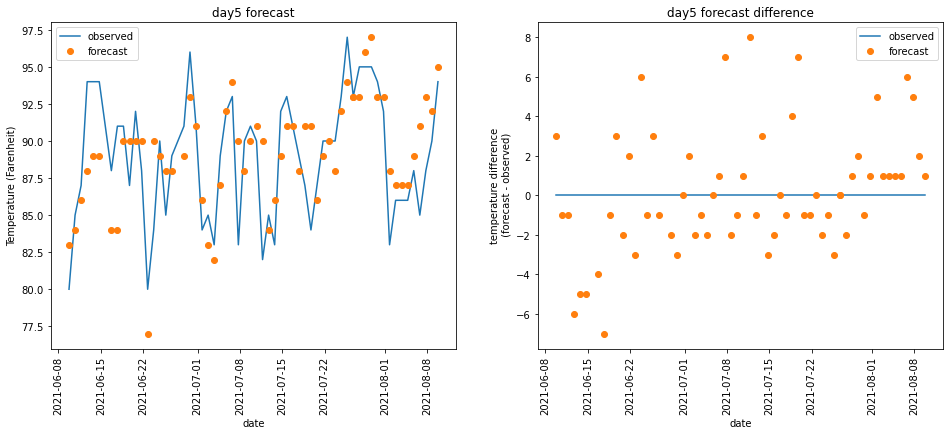

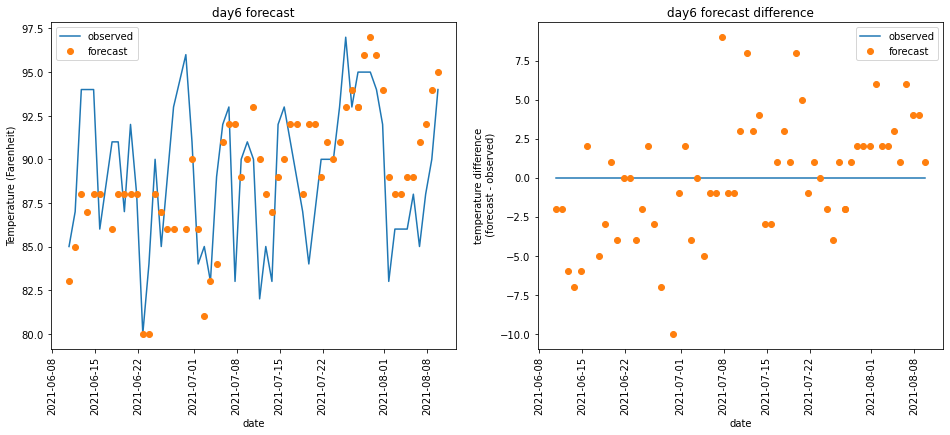

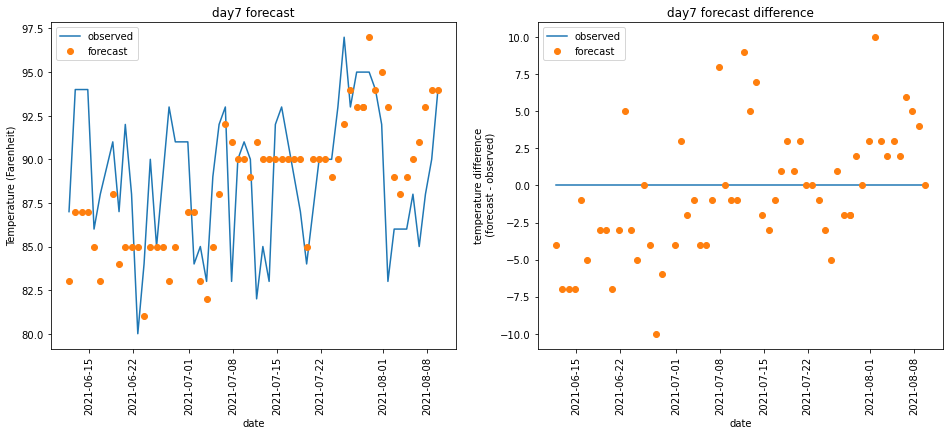

In [13]:
dayList = [day1, day2, day3, day4, day5, day6, day7]

for day in dayList:
    plotForecast(day)

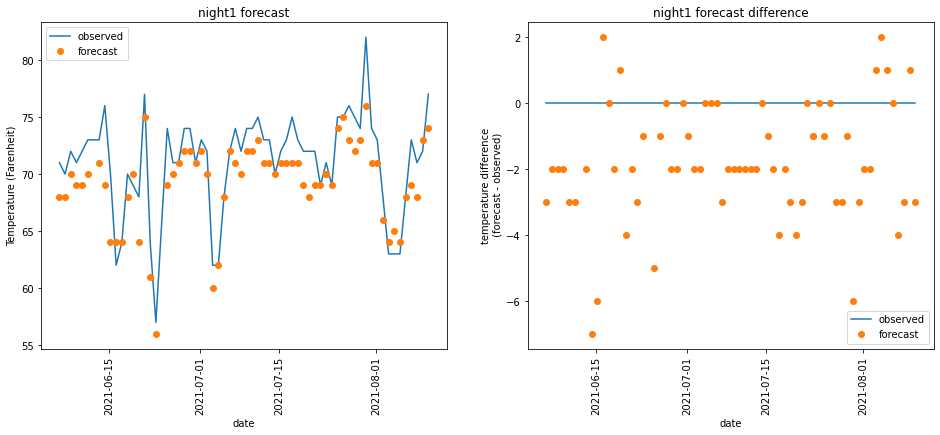

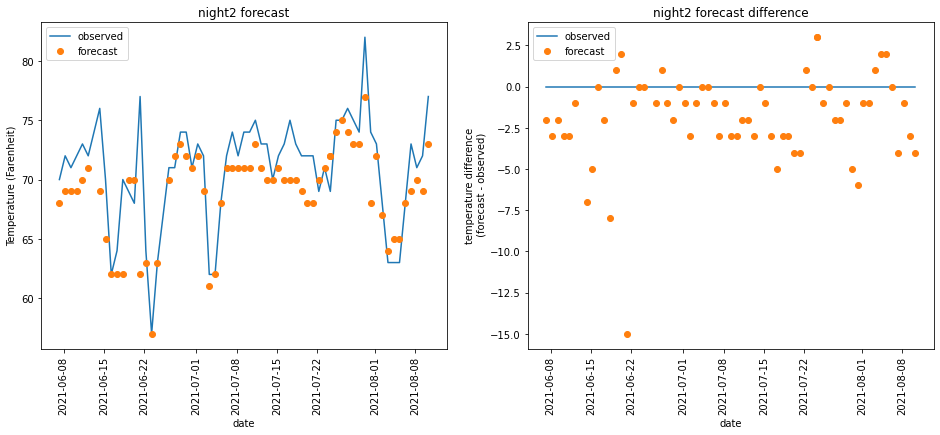

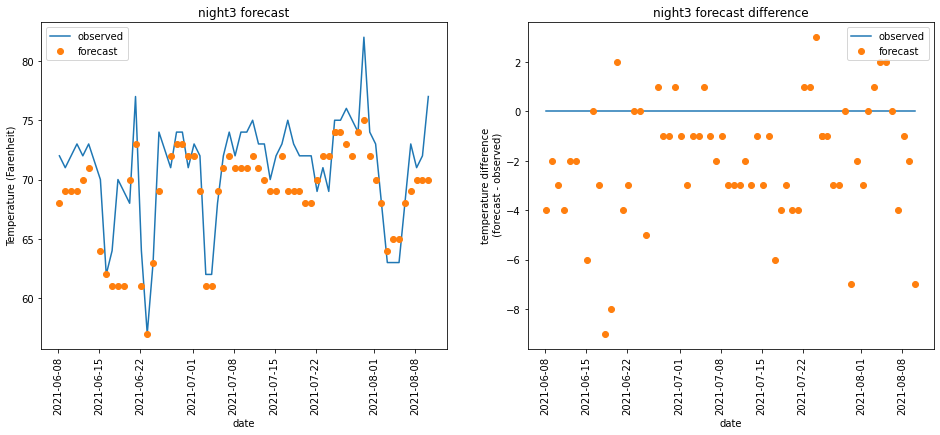

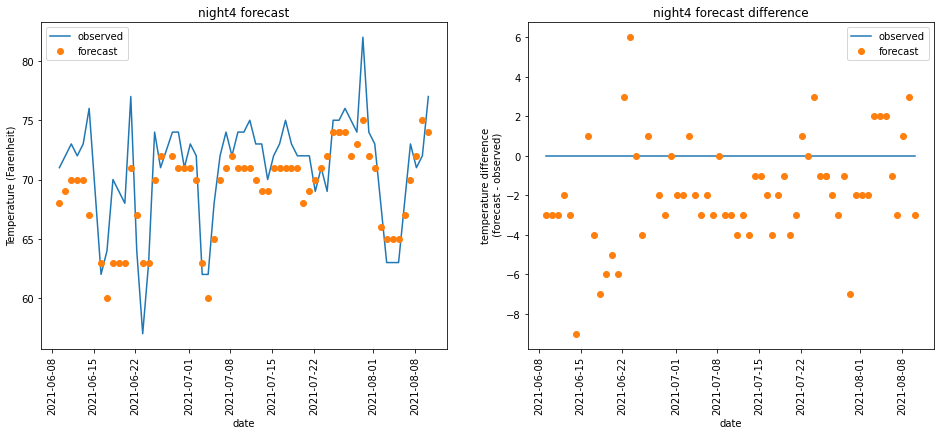

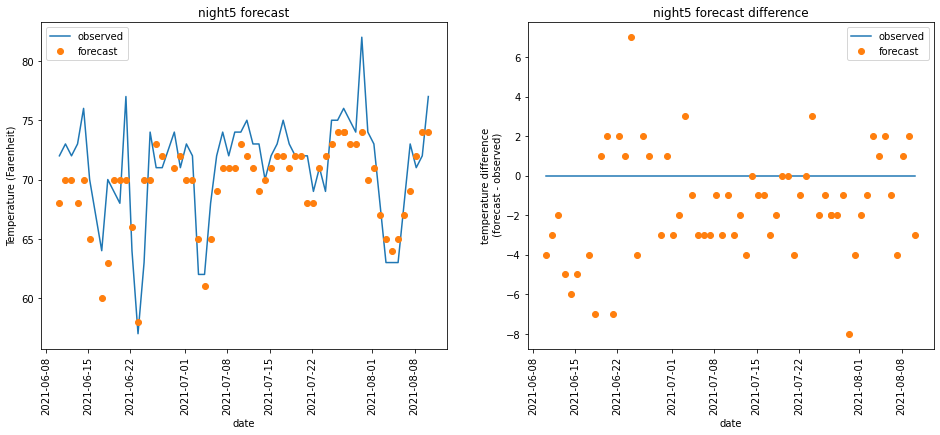

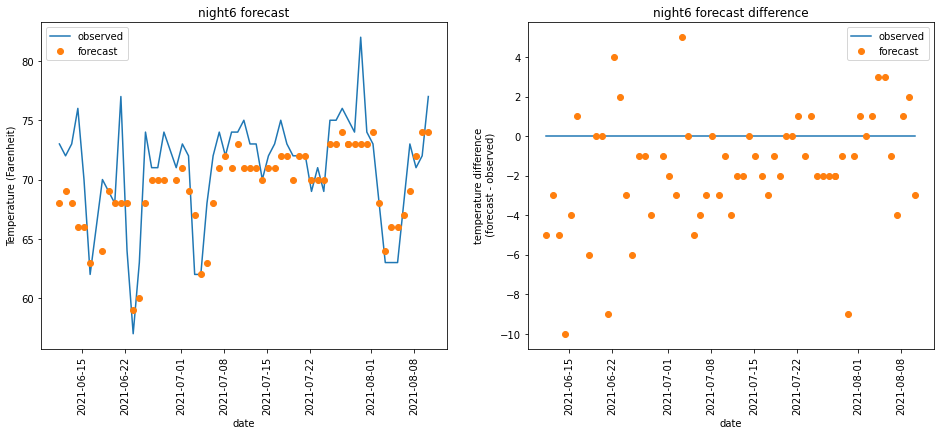

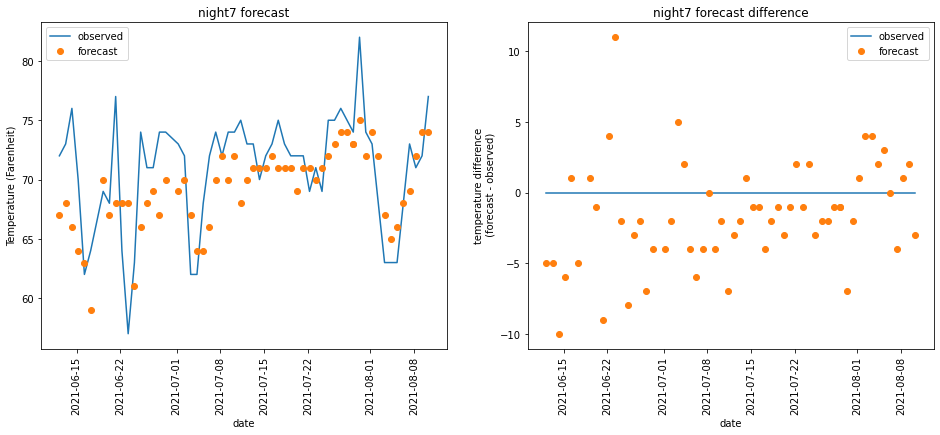

In [14]:
nightList = [night1, night2, night3, night4, night5, night6, night7]

for night in nightList:
    plotForecast(night)

Calculate summary statistics for the temperature difference for daytime highs and nightime lows

In [15]:
dayName = ['1', '2', '3', '4', '5', '6', '7']

dayStats = pd.DataFrame()
for i in range(len(dayList)):
    df = dayList[i]
    dayStats[dayName[i]] = df['tempDiff'].describe()

dayStats

,1,2,3,4,5,6,7
count,65.000000,64.000000,63.000000,62.000000,61.000000,60.000000,59.000000
mean,-0.307692,-0.625000,-0.666667,-0.274194,0.147541,-0.033333,-0.474576
std,2.772201,2.881248,3.032086,2.723121,3.140255,3.861881,4.244087
min,-10.000000,-9.000000,-8.000000,-6.000000,-7.000000,-10.000000,-10.000000
25%,-2.000000,-2.250000,-2.000000,-2.000000,-2.000000,-2.250000,-3.000000
50%,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000
75%,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.500000
max,5.000000,6.000000,8.000000,6.000000,8.000000,9.000000,10.000000


In [16]:
nightName = ['1', '2', '3', '4', '5', '6', '7']

nightStats = pd.DataFrame()
for i in range(len(nightList)):
    df = nightList[i]
    nightStats[nightName[i]] = df['tempDiff'].describe()

nightStats

,1,2,3,4,5,6,7
count,65.000000,64.000000,63.000000,62.000000,61.000000,60.000000,59.000000
mean,-1.784615,-1.828125,-2.015873,-1.806452,-1.524590,-1.683333,-1.677966
std,1.815664,2.780628,2.478892,2.660203,2.742302,2.925584,3.720589
min,-7.000000,-15.000000,-9.000000,-9.000000,-8.000000,-10.000000,-10.000000
25%,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-4.000000
50%,-2.000000,-1.000000,-2.000000,-2.000000,-2.000000,-1.500000,-2.000000
75%,0.000000,0.000000,-0.500000,-0.250000,0.000000,0.000000,1.000000
max,2.000000,3.000000,3.000000,6.000000,7.000000,5.000000,11.000000


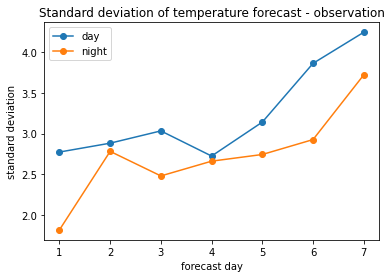

In [17]:
plt.plot(dayStats.loc['std'], marker='o', label='day')
plt.plot(nightStats.loc['std'], marker='o', label='night')
plt.legend()
plt.xlabel('forecast day')
plt.ylabel('standard deviation')
plt.title('Standard deviation of temperature forecast - observation');

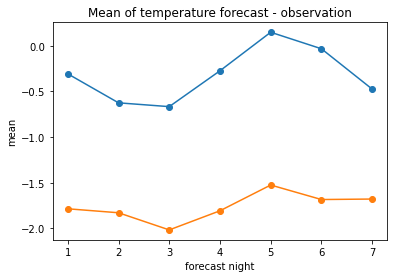

In [18]:
plt.plot(dayStats.loc['mean'], marker='o', label='day')
plt.plot(nightStats.loc['mean'], marker='o')
plt.xlabel('forecast night')
plt.ylabel('mean')
plt.title('Mean of temperature forecast - observation');

In [19]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


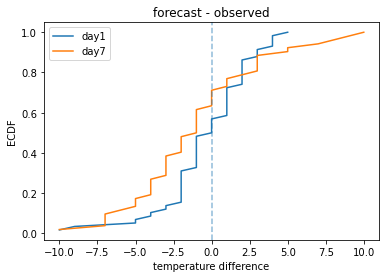

In [20]:
x1, y1 = ecdf(day1['tempDiff'].iloc[:-7])
x7, y7 = ecdf(day7['tempDiff'].iloc[:-7])

plt.plot(x1, y1, label='day1')
plt.plot(x7, y7, label='day7')
plt.axvline(0, linestyle='--', alpha=0.5)
plt.title('forecast - observed')
plt.xlabel('temperature difference')
plt.ylabel('ECDF')
plt.legend();

## Significance testing between temperature differences

The differences between the forecast temperatures and the observed temperatures for different forecast days have different standard deviations. The standard deviations range from ~3 to ~4 from the first forecast day to the last forecast day. The question becomes, is this 1 deg F difference in the standard deviation between the first and last day significant? I use permutations to test the null hypothesis that the standard deviations that the forecast - observed temperatures for the first and last forecast days are the same. 

In [21]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2


def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


def diff_of_std(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of std of data_1, data_2: diff
    diff = np.std(data_1) - np.std(data_2)

    return diff

In [22]:
input1 = day1['tempDiff'].iloc[:-7]
input2 = day7['tempDiff'].iloc[:-7]

# Compute difference of std 
empirical_diff_std = diff_of_std(input1, input2)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(input1, input2,
                                 diff_of_std, size=10000)

# Compute p-value: p
perm_p = np.sum(perm_replicates <= empirical_diff_std) / len(perm_replicates)

A more traditional statistical test to test the equality of the variance between two or more groups is Levene's test.

In [23]:
from scipy.stats import levene

stat, levene_p = levene(input1, input2)

In [24]:
print('Permutation p-value =', perm_p)
print('Levene test p-value =', levene_p)

Permutation p-value = 0.0114
Levene test p-value = 0.029600526252574758


#### Significance testing results

Both the permutation test and the Levene tests give low p-values for the standard deviation between the forecast and observed temperatures from the first and last forecast days. The low p-values suggest that the temperature forecasts for day 7 are less certain than those for day 1. So when looking at a forecast, you can expect the actual temperature to have a 1s uncertainty of about 3 degrees for the first 5 days, and about 4 degrees for days 6 and 7. 

### Boxplots to visualize the temperature differences for the daytime and nighttime forecasts

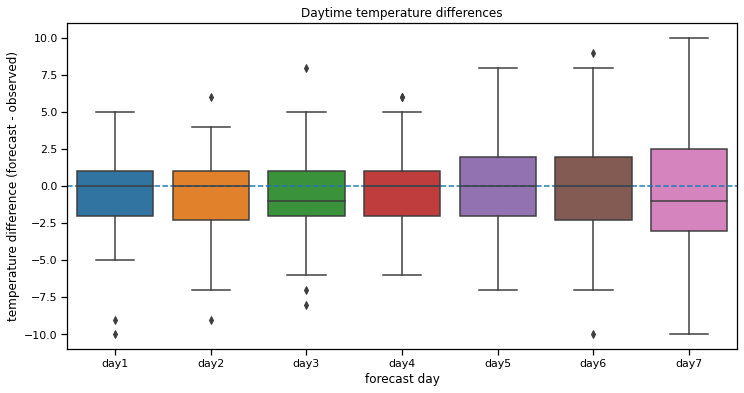

In [25]:
sns.set_context('notebook')

fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='forecastDay', y='tempDiff', data=forecast_obs[forecast_obs['isDaytime']], ax=ax)
plt.axhline(0, linestyle='--')
plt.ylabel('temperature difference (forecast - observed)')
plt.xlabel('forecast day')
plt.title('Daytime temperature differences');

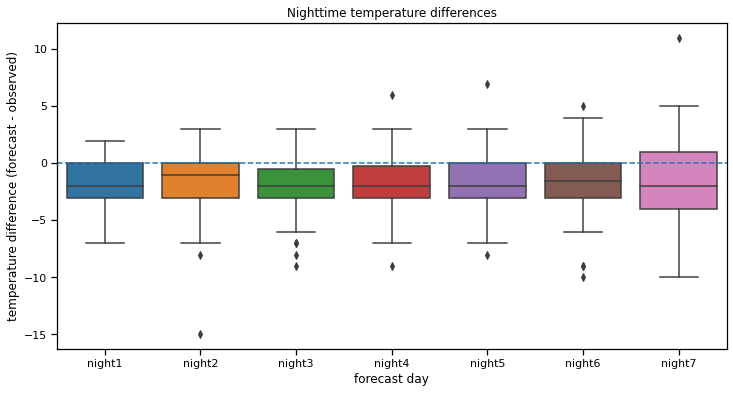

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='forecastDay', y='tempDiff', data=forecast_obs[~forecast_obs['isDaytime']], ax=ax)
plt.axhline(0, linestyle='--')
plt.ylabel('temperature difference (forecast - observed)')
plt.xlabel('forecast day')
plt.title('Nighttime temperature differences');

#### Temperature forecast conclusions

As was seen in the plots above, and the summary statistics, the daytime forecasts are pretty accurate on average. However, for the overnight lows, the actual observed temperatures are consistently higher than what is forecast. My hypothesis is that this is an [urban effect](https://en.wikipedia.org/wiki/Urban_heat_island). The weather station where the observations are from is the Nashville International Airport, so the station is likely surrounded by concrete and tarmac, which absorbes heat from the sun during the day, then radiates it back out at night. The forecast air temperatures must not take this extra radiative heat into account, thus the actual observed temperature is higher than what is expected from the forecast. 

The standard deviation of the temperature differences between the forecasts and observations is about 3 degrees for the first five days and 4 degrees for days 6 and 7. This shows that the temperature forecasts are fairly precise overall, but are less precise the farther out the forecasts are. 

## Working with rainfall data

Most of the time when I look at the weather, I'm most concerned with if it is going to rain and if so, how much? Here, I take each forecast that predicted a certain percentage of rainfall (from 0 to 100%) and add up all the times it actually rained to calculate the actual percentage of time it rained. If the forecast percent chance of rain is accurate, then over time, it should actually rain the same percentage of time. For example, if over a year there are 20 day3 forecasts of a 50% chance of rain, we would expect that 10 of those 20 days to have some rainfall. 

In [27]:
# setup lists to iterate over
percentage = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dfList = [day1, night1, day2, night2, day3, night3, day4,
          night4, day5, night5, day6, night6, day7, night7]
nameList = ['day1', 'night1', 'day2', 'night2', 'day3', 'night3', 'day4',
          'night4', 'day5', 'night5', 'day6', 'night6', 'day7', 'night7']
rainPercentCompare = pd.DataFrame(index=percentage)
rainPercentCounts = pd.DataFrame(index=percentage)
rainCounts = pd.DataFrame(index=percentage)

rainPercent_obs = []
rainCounts1 = []
for i, df in enumerate(dfList):
    for val in percentage:
        # counts of the forecast % rainfall
        counts = df['precip%'].value_counts().sort_index()
        # fill output cell with NaN if no rain was forecast at that percentage
        if (df['precip%'] == val).sum() == 0:
            rainPercent_obs.append(np.nan)
            rainCounts1.append(np.nan)
        else:
            # calculate the actual observed percent rainfall for each forecast percent
            rainPercent_obs.append(100*(df[df['precip%'] == val]['rain?'].sum()/counts[val]))
            # count the number of times it rained for each forecast percent rainfall
            rainCounts1.append(df[df['precip%'] == val]['rain?'].sum())
    
    # build DataFrames of rainfall data for all forecasts
    
    # the actual observed percent rainfall for each forecast percent
    rainPercentCompare[nameList[i]] = pd.DataFrame(rainPercent_obs, index=percentage)
    # number of times each percent chance of rain was forecast
    rainPercentCounts[nameList[i]] = pd.DataFrame(counts, index=percentage)
    # number of times it actually rained for each forecast percent rainfall
    rainCounts[nameList[i]] = pd.DataFrame(rainCounts1, index=percentage)
    rainPercent_obs = []
    rainCounts1 = []


Visualizing the percent chance of rain vs. the actual percentage of time it rains. If the forecast was perfectly accurate, then all the points on the plots would plot on the 1:1 line.

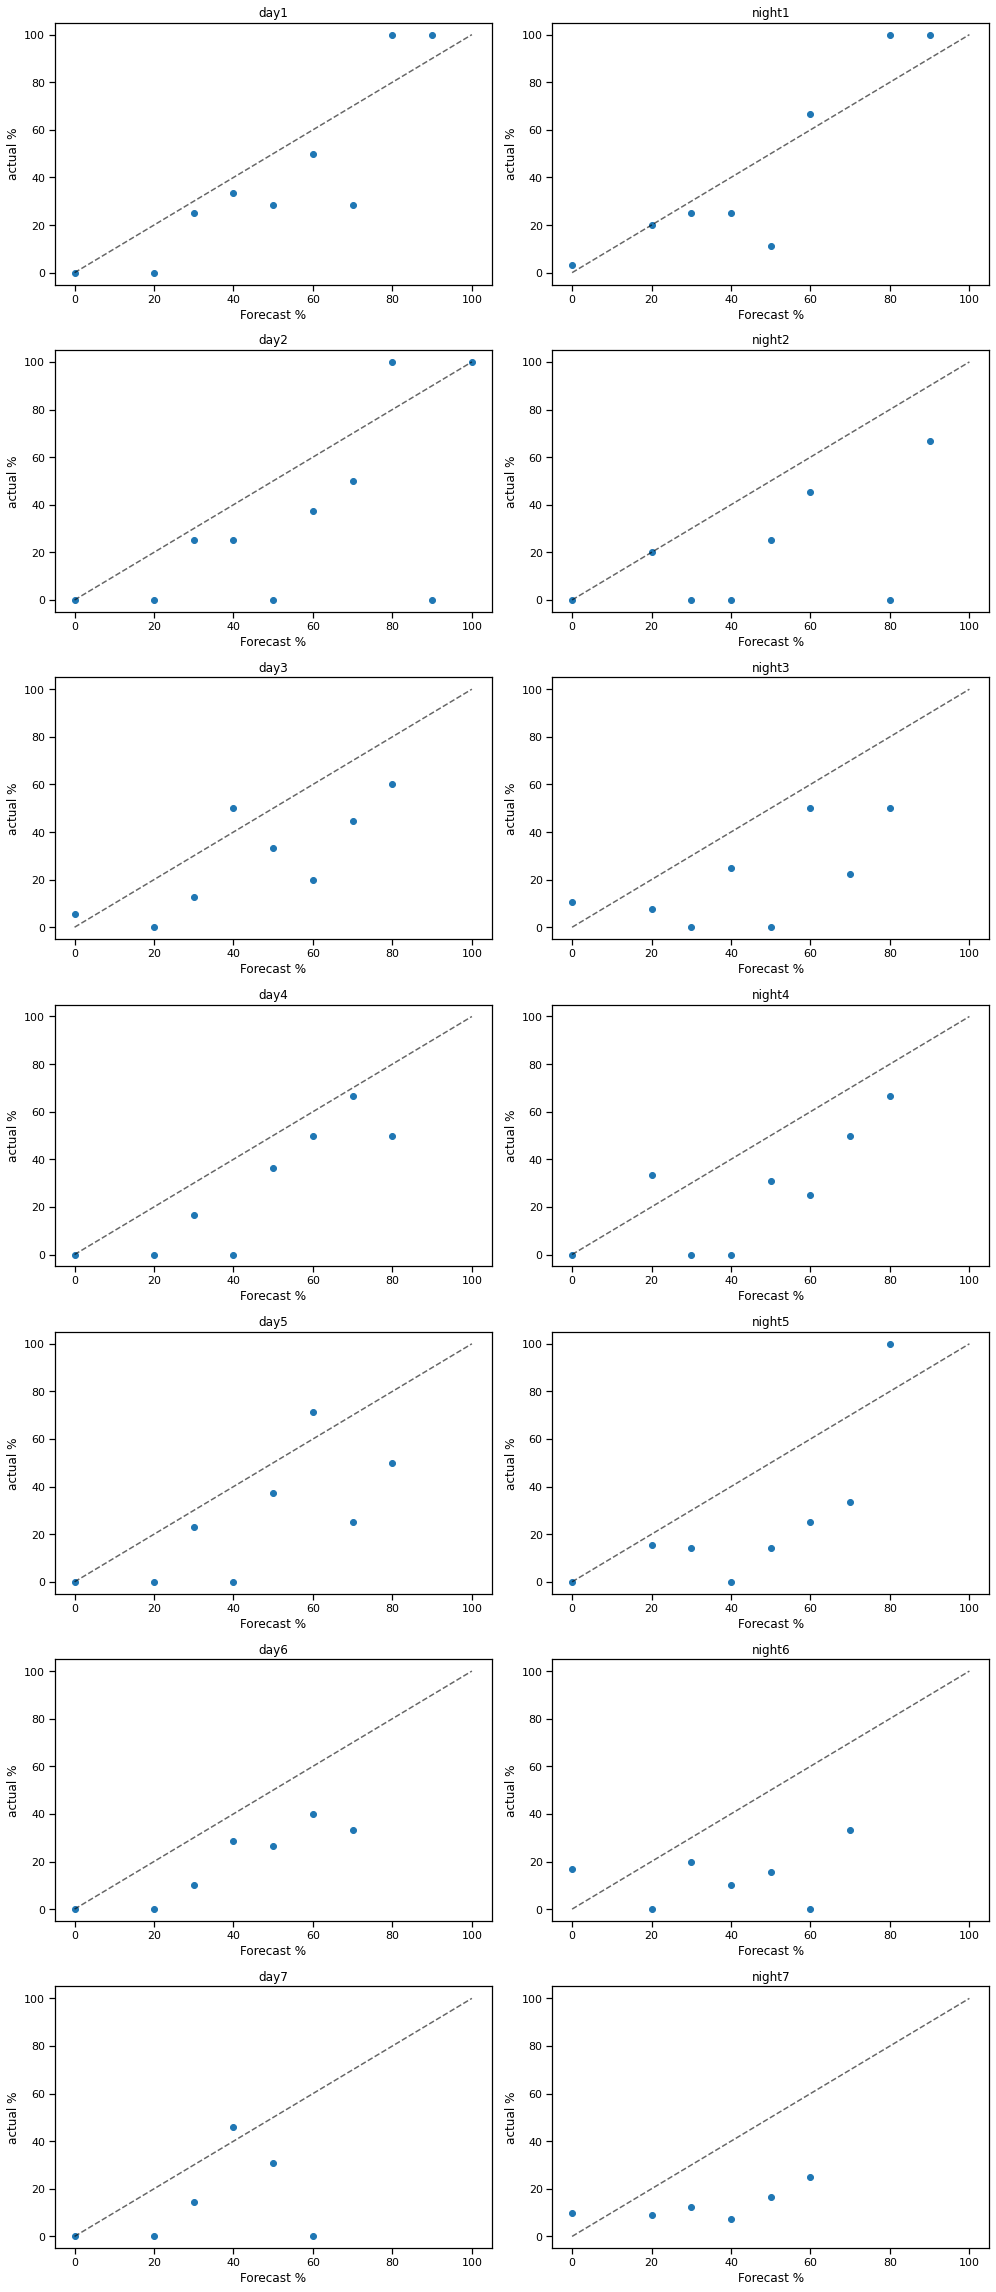

In [28]:
plt.subplots(figsize=(14,32))
for i in range(len(nameList)):
    plt.subplot(7,2,i+1)
    plt.scatter(rainPercentCompare.index, rainPercentCompare[nameList[i]])
    plt.plot([0,100], [0, 100], '--', color='k', alpha=0.6)
    ax.margins(0.2)
    plt.xlabel('Forecast %')
    plt.ylabel('actual %')
    plt.title(nameList[i])
    plt.tight_layout()

The Nashville office of National Weather Service only gives a forecast of rainfall amounts for the day1, night1, and day2 forecasts. Here I visualize the actual rainfall relative to the forecasts. 

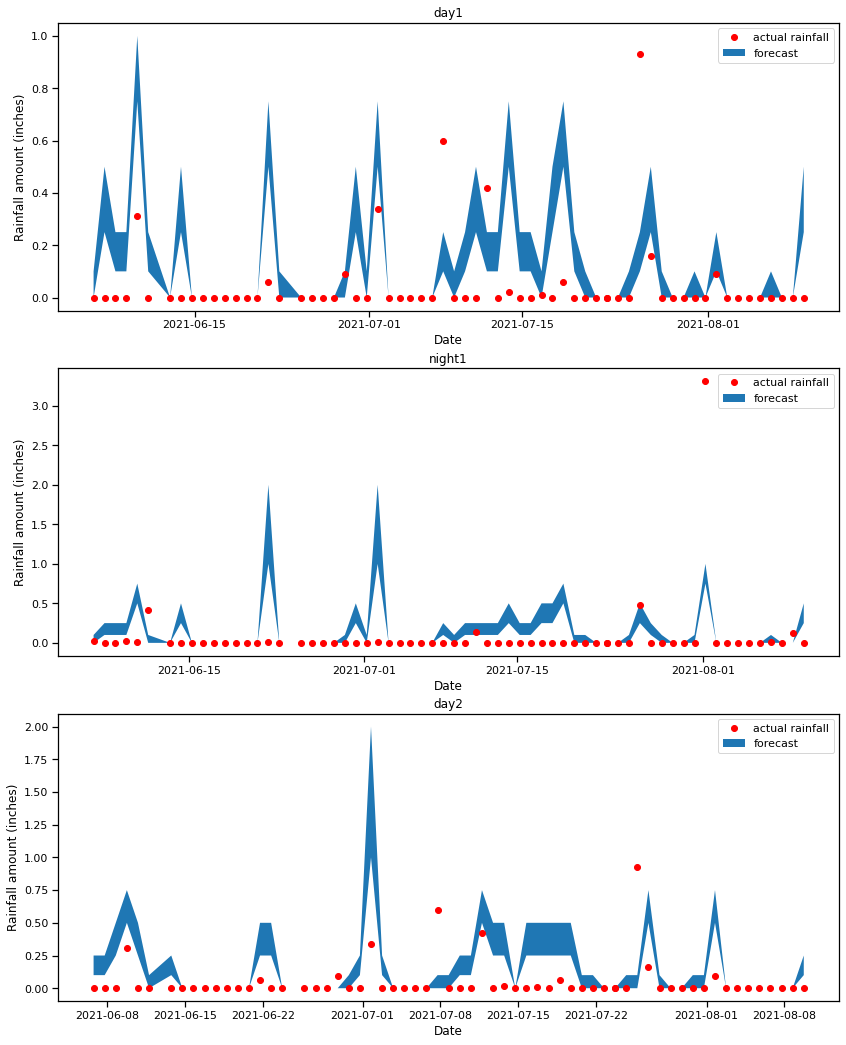

In [31]:
plt.subplots(figsize=(14,18))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.fill_between(dfList[i]['endTime'], dfList[i]['rain low'], dfList[i]['rain high'], label='forecast')
    plt.plot(dfList[i]['endTime'], dfList[i]['Precip_obs'], marker='o', linestyle='None', 
             color='red', label='actual rainfall')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Rainfall amount (inches)')
    plt.title(nameList[i])

#### Rainfall conclusions

Over the time of this study, the forecast percent chance of rain underestimates the actual percent of time that it rains at this weather station. Maybe over a longer period of time and during different seasons, these chance of rain forecasts could better match the true amount of time that it rains. Likewise, the forecast rainfall amounts are rarely accurate. Most of the time, the forecast rainfall amounts overestimate the true rainfall amounts, with a few exceptions. For instance, overnight on August 1, it was forecast to rain between 0.75 and 1 inch but it actually rained over 3 inches. 

# Conclusions

I have always wondered how precise and accurate weather forecasts are. Based on the data presented here, average daytime temperature forecasts for Nashville for all forecast days are fairly accurate. The precision, based on the standard deviation of differences between the forecast and observations does increase with forecast day, from a standard deviation of about 3 degrees for the first 5 days to about 4 degrees for days 6 and 7. Surprisingly, the nighttime observed temperatures were all consistently hotter than the forecasts for all forecast days. This is likely due to the "urban heat island" effect. The precision of nighttime forecasts is similar to the daytime forecasts.

Based on the limited number of observations over the first two months of this study, the percent chance of rain forecasts are fairly accurate. This will be better assessed with more observations over a longer period of time. The forecast rainfall amounts are rarely accurate. The discrepancies in the rainfall forecasts may in part be explained by the fact that the forecasts are given for a relatively large geographic area, but actual rainfall is location specific. So it is highly likely that on some day where it was forecast to rain, there was either no rain recorded or a different amount fell at this particular weather station. My personal experience bears this out as well.


#### Future work

I plan to continue to retrieve these weather forecasts and observations to see how these initial conclusions hold up with more data. I am especially interested to test whether forecast accuracy and precision changes with the different seasons. 